In [1]:
import time
import cv2
import polanalyser as pa
from PIL import Image
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import numpy as np
import os
import sys
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from scipy import ndimage

%matplotlib notebook
import importlib
pyfilepath = '..//controller.py'
dirname, basename = os.path.split(pyfilepath) 
sys.path.append(dirname) 
module_name = 'controller'
controller = importlib.import_module(module_name) 

# CONECT TO CAMERA

In [2]:
imager = controller.Imager()
num_cams = len(imager.cams)

Found 1 devices
Devices IDs - ['101933']


In [3]:
exposure=30000 # set exposure time in micro-seconds

imager.cams[-1].remote_device.node_map.ExposureAuto.value = 'Off'
PIXELFORMATS = {'8':'Mono8','12':'Mono12Packed'}

PIXELFORMAT = PIXELFORMATS['12']  # set pixel format
imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)
imager._start_acquisitions()
time.sleep(1)

# Tune exposure time

In [39]:
exposure=10000 

while(True):
    
    print('1')
#     imager._stop_acquisitions()
    imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)
#     imager._start_acquisitions()
    print('2')
    img, _ = imager.capture_sequence(1,0,0)
    time.sleep(0.1)
    img = np.squeeze(np.array(img))
    print('3')
    e = np.argwhere(img>=0.9*(2**12))
    print(exposure)
    print((len(e)/(img.shape[0]*img.shape[1])))
    if (len(e)/(img.shape[0]*img.shape[1])) < 0.01: # No saturation?
        break
    else:
        exposure = exposure - 1000

print("the found exposure time is {}".format(exposure))

1
2
0 - 2022-01-05 11:12:37.852173 - 101933 captured Mono12Packed image 
3
10000
0.021279927172691993
1
2
0 - 2022-01-05 11:12:38.539527 - 101933 captured Mono12Packed image 
3
9000
0.012562670738868464
1
2
0 - 2022-01-05 11:12:39.219282 - 101933 captured Mono12Packed image 
3
8000
0.002642263773999183
the found exposure time is 8000


In [37]:
# exposure=8000 
# imager.update_params(ExposureTime=exposure, PixelFormat=PIXELFORMAT)

<IPython.core.display.Javascript object>


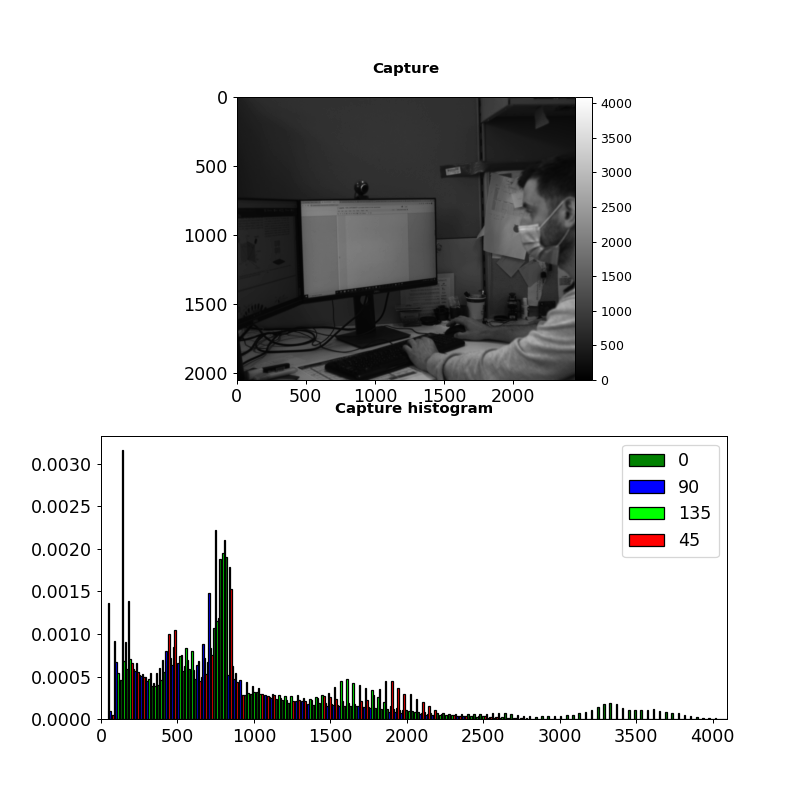

0 - 2022-01-05 11:12:43.311606 - 101933 captured Mono12Packed image 


In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
ax = ax.flatten()

img, _ = imager.capture_sequence(1,0,0)
img = np.squeeze(np.array(img))


im_0   = img[3::4, 3::4]
im_90  = img[2::4, 2::4]
im_135 = img[3::4, 2::4]
im_45  = img[2::4, 3::4]

colors = ['green', 'blue', 'lime','red']
labels = ['0','90','135','45']

data_for_hist = np.vstack([im_0.ravel(),im_90.ravel(),im_135.ravel(),im_45.ravel()]).T

if PIXELFORMAT == 'Mono12Packed':
    im = ax[0].imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=2**12)

else:
    im = ax[0].imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=2**8)


divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(im, cax=cax)
ax[0].tick_params(labelsize=14)
ax[0].set_title('Capture\n',
          fontweight ="bold")


# the histogram of the data
if PIXELFORMAT == 'Mono12Packed':
    ax[1].hist(data_for_hist, 100, density = True, 
         histtype ='bar',
         color = colors,
         label = labels,edgecolor='k',rwidth=20)
    # nice reference - https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca



    ax[1].set_xlim([0,2**12])
else:
    ax[1].hist(data_for_hist, 100, density = True, 
         histtype ='bar',
         color = colors,
         label = labels,edgecolor='k')

    ax[1].set_xlim([0,2**8])

ax[1].legend(prop ={'size': 14})

ax[1].set_title('Capture histogram\n',
          fontweight ="bold")

ax[1].tick_params(labelsize=14)


# REAL TIME STREAMING

In [41]:
num_images = 1
break_sets = 0 #in seconds
break_images = 0 # if == 0: 3 images are taken with no break (for repetition),
                         # then then there is a break_sets.
                         # if break_sets == break_images,
                         # there is no repetition.
            
raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)

0 - 2022-01-05 11:12:47.022499 - 101933 captured Mono12Packed image 


In [42]:
metadata

[(0, datetime.datetime(2022, 1, 5, 11, 12, 47, 22499), '101933')]

In [43]:
# REAL_TIME CAPTURE
font = cv2.FONT_HERSHEY_SIMPLEX
frame_cnt = 0

title = 'Real time stream'
cv2.namedWindow(title, cv2.WINDOW_NORMAL)

while(True):
    
#     start = time.time()
    raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)
#     print("Executing an iteration took {} seconds".format(time.time()-start))
    
    raw_images = np.squeeze(np.array(raw_images))
    if num_images > 1:
        mean_image = np.mean(raw_images,axis=0)

    else:
        mean_image = raw_images
        
    frame_show = mean_image.copy()
    
    cv2.putText(frame_show,'Frame {}'
                .format(int(frame_cnt)),(10,50), font, 2,(255),2,cv2.LINE_AA)
    
    frame_cnt = frame_cnt + 1
    
    if PIXELFORMAT == 'Mono12Packed':
        frame_show = (2**8)*(frame_show/(2**12))
    
    frame_show = frame_show.astype('uint8')
    cv2.imshow(title, frame_show)
    
    key = cv2.waitKey(1) 
    # waitKey(1) will display a frame for 1 ms, after which display will be automatically closed.
    # Since the OS has a minimum time between switching threads, the function will not wait exactly 1 ms, it will 
    # wait at least 1 ms, depending on what else is running on your computer at that time.
    if key==ord('q'):
        break
        
    
 
cv2.destroyAllWindows()   

0 - 2022-01-05 11:12:48.399062 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:49.039383 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:49.634358 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:50.260122 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:50.874515 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:51.472959 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:52.060458 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:52.665807 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:53.259809 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:53.860890 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:54.454302 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:55.067161 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:55.668317 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:56.268577 - 101933 captured Mono12Packed image 
0 - 2022-01-05 11:12:56.864194 - 1

In [10]:
cv2.destroyAllWindows()  

# One frame processing

<IPython.core.display.Javascript object>


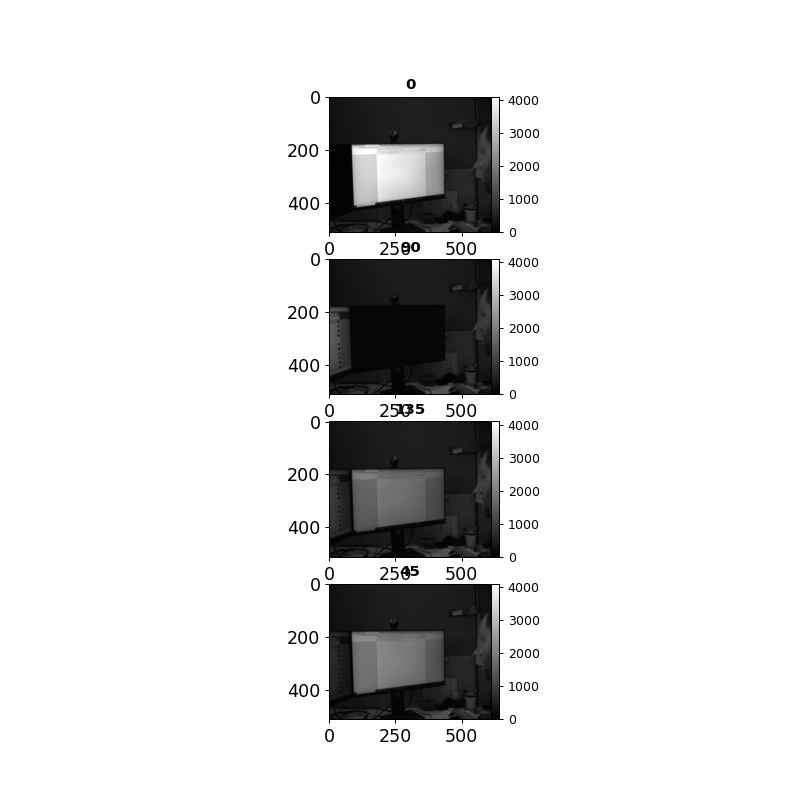

0 - 2022-01-05 09:52:45.630532 - 101933 captured Mono12Packed image 


In [6]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (10,10))
ax = ax.flatten()

img, _ = imager.capture_sequence(1,0,0)
img = np.squeeze(np.array(img))

colors = ['green', 'blue', 'lime','red']
labels = ['0','90','135','45']

im_0   = img[3::4, 3::4]
im_90  = img[2::4, 2::4]
im_135 = img[3::4, 2::4]
im_45  = img[2::4, 3::4]

angles = np.deg2rad([0, 45, 90, 135])

for i, im in enumerate([im_0,im_90,im_135,im_45]):
    imu = ax[i].imshow(im, cmap=plt.get_cmap('gray'), vmin=0, vmax=2**12)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0)
    plt.colorbar(imu, cax=cax)
    
    ax[i].tick_params(labelsize=14)
    ax[i].set_title(labels[i],
          fontweight ="bold")





# Save images every 1 min

In [9]:
frame_cnt = 0
num_images = 1

experiment = "ASRI1"
directory = f"./{experiment}_{exposure}"
if not os.path.exists(directory):
    os.mkdir(directory)
    
    
while(True):
    
#     start = time.time()
    raw_images, metadata = imager.capture_sequence(num_images, break_sets,break_images)
#     print("Executing an iteration took {} seconds".format(time.time()-start))
    
    raw_images = np.squeeze(np.array(raw_images))
    if num_images > 1:
        mean_image = np.mean(raw_images,axis=0)

    else:
        mean_image = raw_images
    
    info = metadata[-1][1].strftime("%Y_%m_%d_%H%M%S")
    np.save(f'./{directory}/frame_{frame_cnt}_{info}', mean_image)
    
    if PIXELFORMAT == 'Mono12Packed':
        mean_image = (2**8)*(mean_image/(2**12))
    
    frame_show = mean_image.astype('uint8')
    
    cv2.imwrite(f'./{directory}/frame_{frame_cnt}_{info}'+'.png',mean_image)
    
    frame_cnt = frame_cnt + 1

    time.sleep(60)
    
    k = cv2.waitKey(1) & 0xFF
    # press 'q' to exit
    if k == ord('q'):
        break
        


0 - 2022-01-05 09:53:02.672018 - 101933 captured Mono12Packed image 
0 - 2022-01-05 09:54:03.302805 - 101933 captured Mono12Packed image 
0 - 2022-01-05 09:55:03.926040 - 101933 captured Mono12Packed image 
0 - 2022-01-05 09:56:04.568672 - 101933 captured Mono12Packed image 
0 - 2022-01-05 09:57:05.193992 - 101933 captured Mono12Packed image 
0 - 2022-01-05 09:58:05.824215 - 101933 captured Mono12Packed image 
0 - 2022-01-05 09:59:06.456258 - 101933 captured Mono12Packed image 
0 - 2022-01-05 10:00:07.087267 - 101933 captured Mono12Packed image 
0 - 2022-01-05 10:01:07.722320 - 101933 captured Mono12Packed image 
0 - 2022-01-05 10:02:08.364376 - 101933 captured Mono12Packed image 
0 - 2022-01-05 10:03:09.000077 - 101933 captured Mono12Packed image 
0 - 2022-01-05 10:04:09.633343 - 101933 captured Mono12Packed image 
0 - 2022-01-05 10:05:10.264949 - 101933 captured Mono12Packed image 
0 - 2022-01-05 10:06:10.888905 - 101933 captured Mono12Packed image 
0 - 2022-01-05 10:07:11.524520 - 1

KeyboardInterrupt: 

# Make a video from the above captured frames

In [21]:
from PIL import Image, ImageDraw, ImageFont
import glob

IMG_H , IMG_W = mean_image.shape[0] , mean_image.shape[1]
filename = os.path.join(directory,'video.avi')
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
video = cv2.VideoWriter(
            filename,
            fourcc,    #cv2.VideoWriter_fourcc('X','2','6','4'),
            30,
            (IMG_W, IMG_H)
        )

font = ImageFont.truetype("C:/Windows/Fonts/arialbd.ttf", 40, encoding="unic")
image_names = sorted(glob.glob(directory+'\\*.png'))
image_names = sorted(image_names, key=lambda x: int(x.split('\\')[-1].split('_')[1]))

fcolor=(255,0,0)

for idx, image_name in enumerate(image_names):
    print(idx)
    image_ = cv2.imread(image_name)
    image_ = Image.fromarray(np.uint8(image_))
    draw = ImageDraw.Draw(image_)
    img_text = 'Frame_{}'.format(idx)
    
    draw.text(
        (0, 0),
        img_text,
        fill = fcolor,
        font=font
        )    
    
    image_ = np.array(image_)
    video.write(image_)

video.release()
print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
done


In [26]:
a = np.load('ASRI1_7000//frame_35_2022_01_05_102825.npy')
a.max()

3902